* https://www.sciencedirect.com/science/article/pii/S2352340918315191
* https://www.kaggle.com/marcuswingen/eda-of-bookings-and-ml-to-predict-cancelations


<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-gr1.jpg">

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
file_path = "data/hotel_bookings.csv"
df = pd.read_csv(file_path)
df.shape

(119390, 32)

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
label_name = "is_canceled"

In [5]:
X, y = df.drop(columns=[label_name, "reservation_status_date"]), df[label_name] == 1
X.shape, y.shape

((119390, 30), (119390,))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42)

In [7]:
X.select_dtypes(exclude="number").nunique()

hotel                     2
arrival_date_month       12
meal                      5
country                 177
market_segment            8
distribution_channel      5
reserved_room_type       10
assigned_room_type       12
deposit_type              3
customer_type             4
reservation_status        3
dtype: int64

In [8]:
categorical_feature = X.select_dtypes(exclude="number").columns
categorical_feature

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status'],
      dtype='object')

In [9]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train[categorical_feature] = oe.fit_transform(X_train[categorical_feature])
X_valid[categorical_feature] = oe.transform(X_valid[categorical_feature])

In [10]:
#!pip install xgboost

In [11]:
import xgboost as xgb
        
model_xgb = xgb.XGBClassifier(n_estimators=1000,
                              learning_rate=0.05,
                              max_depth=3,
                              random_state=42,
                              n_jobs=-1,
                              tree_method="hist",
                              enable_categorical=True)
model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [12]:
es = xgb.callback.EarlyStopping(
    rounds=5,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name=["r2"],
)

model_xgb.set_params(callbacks=[xgb.callback.EarlyStopping(rounds=10, save_best=True)])

history = model_xgb.fit(X_train, y_train, 
                        eval_set=[(X_valid, y_valid)], verbose=False)

<Axes: >

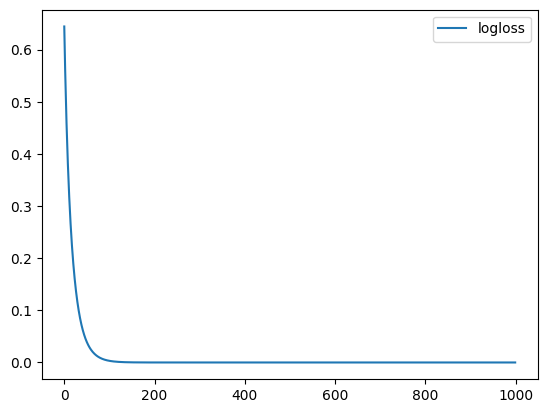

In [13]:
pd.DataFrame(history.evals_result_["validation_0"]).plot()

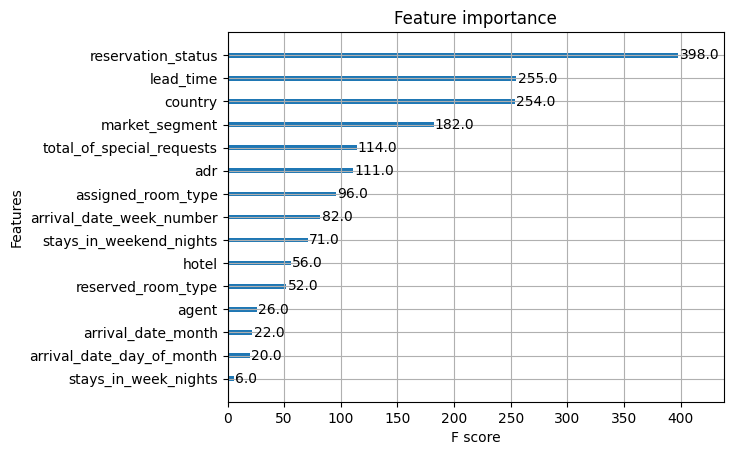

In [14]:
xgb.plot_importance(model_xgb, max_num_features=30);